In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from datetime import datetime, timedelta


In [2]:
amazon_data = pd.read_csv('AMZN.csv', parse_dates=['Date'], index_col=['Date'], dayfirst=True)

In [3]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

1) (5 points) Plot the predicted and true stock price on a test set and describe your observations from this plot with moving average (MA). Requirements: 1) You need to list key steps and their results (e.g., ACF plot) to predict the stock price. You will lose marks if you only show the final plot about prediction; 2) You need to split this dataset into a train (70%) set and a test (30%) set. Use the train set to train the moving average (MA) model and make a prediction on the test set.

In [4]:
amazon_data.head()

,Close
Date,
2021-01-04,3186.629883
2021-01-05,3218.510010
2021-01-06,3138.379883
2021-01-07,3162.159912
2021-01-08,3182.699951


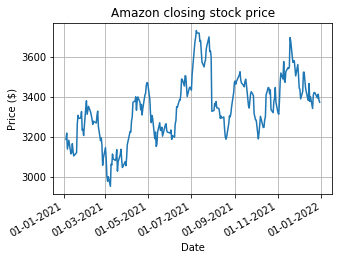

In [5]:
# First, plot the data, and determine if it is stationary. 
ax = amazon_data.plot(figsize=[5,3.5])
ax.grid('on')
ax.set_title('Amazon closing stock price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.get_legend().remove()
ax.figure.savefig('plots/amzn_data.png')

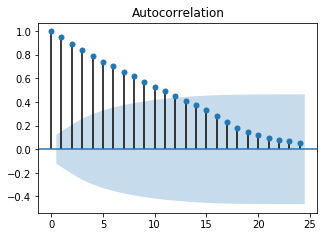

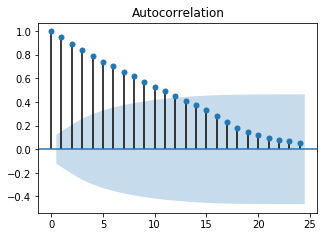

In [22]:
# Plot ACF of Amazon stock prices
fig1, ax1 = plt.subplots(figsize=[5,3.5])
plot_acf(amazon_data, ax=ax1)
# ax1.figure.savefig('plots/amzn_data_acf')

In [23]:
# Test for stationarity using AD Fuller
adf_check(amazon_data['Close'])
adfuller(amazon_data['Close'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.622855913227283
p-value : 0.08836482157882442
Number of Lags Used : 0
Number of Observations Used : 250
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



(-2.622855913227283,
 0.08836482157882442,
 0,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 2496.8187601272616)

TypeError: descriptor 'date' requires a 'datetime.datetime' object but received a 'int'

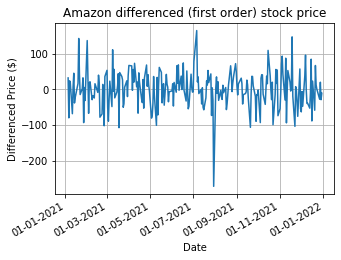

In [24]:
# Clearly, this isn't stationary. So we apply a transformation to make it stationary (first order differencing).

amazon_df = pd.DataFrame(amazon_data.copy())
amazon_df['Shift_1'] = amazon_data['Close'].shift()
amazon_df['Diff_1'] = amazon_df['Close'].diff()
amazon_df = amazon_df[1:]
amazon_df.head()

ax = amazon_df['Diff_1'].plot(figsize=[5,3.5])
ax.grid('on')
ax.set_title('Amazon differenced (first order) stock price')
ax.set_xlabel('Date')
ax.set_ylabel('Differenced Price ($)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.set_xlim([datetime.date(2021, 1, 1), datetime.date(2021, 12, 30)])
ax.figure.autofmt_xdate()
ax.figure.savefig('plots/amzn_diff_data.png')

In [ ]:
# Run DF test again
adf_check(amazon_df['Diff_1'])

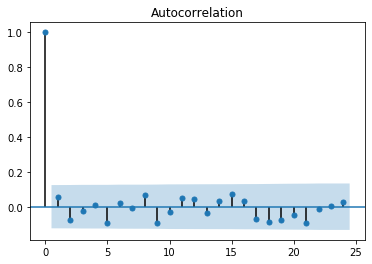

In [25]:
# Ok, now we have stationarity
# Next we plot the ACF 
ax3 = plot_acf(amazon_df['Diff_1'])
ax3.savefig('plots/amzn_diff_acf')

In [26]:
# The ACF disappears after a lag of 0, indicating that there is little correlation between any of the differenced values at different times
# Therefore, a MA model isn't likely to be the best fit, and the stationary series is likely to have come from a random walk process

# Having said this, the most significant lags are at 5 and 9
# Let's cycle through 10 possible lag values and choose the MA model with the smallest error
# First break amazon data into train and test data
train_size = int(np.floor(0.7 * amazon_data.shape[0]))
train_data = amazon_data[0:train_size]
test_data = amazon_data[train_size+1:]
# Now figure out the best order for the MA model on the training data
min_rmse = 1000
best_q = 0
best_model = ARIMA(train_data, order=(0,0,9))
rmses = []
for q in np.arange(13):
    model = ARIMA(train_data, order=(0,0,q))
    model_fit = model.fit()
    rmse = np.sqrt(model_fit.mse)
    rmses.append(rmse)
    if (rmse < min_rmse):
        min_rmse = rmse
        best_q = q
        best_model = model

print("Best score is...")
print(min_rmse)
print(best_q)


/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but 

Best score is...
50.40945814272425
11


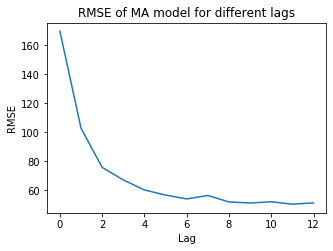

In [27]:
fig, ax = plt.subplots(figsize=[5,3.5])
ax.plot(np.arange(13), rmses)
ax.set_title('RMSE of MA model for different lags')
ax.set_xlabel('Lag')
ax.set_ylabel('RMSE')
fig.savefig('plots/rmse.png')


/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


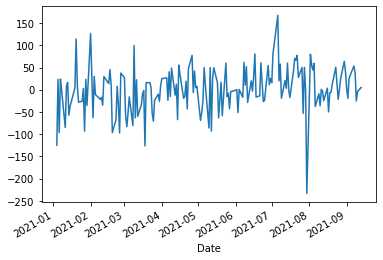

In [28]:
# The lag with the lowest error is a lag of 9
best_model.model_orders

model_fit = best_model.fit()
residuals = model_fit.resid

residuals.plot()


/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parame

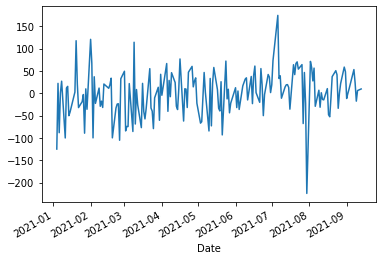

In [29]:
model = ARIMA(train_data, order=(0,0,12))
model_fit = model.fit()
residuals = model_fit.resid
residuals.plot()

In [30]:
# Make predictions and compare to the test set
history = train_data['Close'].tolist()
test = test_data['Close'].tolist()
predictions = []

for i in range(len(test_data)):
    model = ARIMA(history, order=(0,0,12))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    

/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/lukekirwan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: Conver

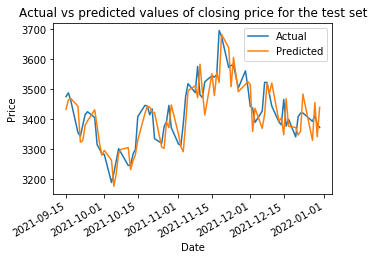

In [31]:
ma_results = pd.DataFrame(amazon_data.copy())

test_results = test_data.copy()
test_results['Predicted'] = predictions

fig, ax = plt.subplots(figsize=[5,3.5])
test_results.plot(ax=ax)
ax.set_title('Actual vs predicted values of closing price for the test set')
ax.set_ylabel('Price')
ax.legend(['Actual', 'Predicted'])
fig.savefig('plots/actual_vs_predictions.png')

TypeError: descriptor 'date' requires a 'datetime.datetime' object but received a 'int'

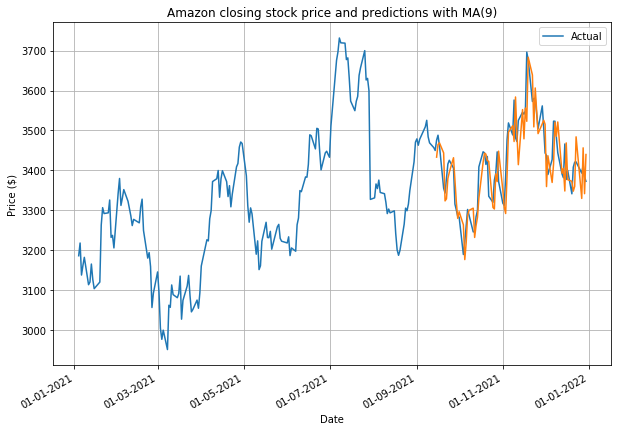

In [32]:
ma_results.rename(columns={'Close':'Actual'}, inplace=True)
res_ax = ma_results.plot(figsize=[10,7])
test_results['Predicted'].plot(ax=res_ax)
res_ax.grid('on')
res_ax.set_title('Amazon closing stock price and predictions with MA(9)')
res_ax.set_xlabel('Date')
res_ax.set_ylabel('Price ($)')
res_ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
res_ax.set_xlim([datetime.date(2021, 1, 1), datetime.date(2021, 12, 30)])
res_ax.figure.autofmt_xdate()
res_ax.legend()
res_ax.figure.savefig('plots/amzn_ma_preds.png')


3) (5 points) Summaries of the process of augmented dickey-fuller test. Use this theory to test and analyze the stationarity of this dataset.

In [33]:
# Original data ADF check
adf_check(amazon_data['Close'])
adfuller(amazon_data['Close'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.622855913227283
p-value : 0.08836482157882442
Number of Lags Used : 0
Number of Observations Used : 250
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



(-2.622855913227283,
 0.08836482157882442,
 0,
 250,
 {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544},
 2496.8187601272616)

In [34]:
# Differenced (first order) data ADF check
adf_check(amazon_data['Close'].diff().dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -14.869402780892328
p-value : 1.672227138392629e-27
Number of Lags Used : 0
Number of Observations Used : 249
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


4) (10 points) Plot the predicted volatility based on the estimated GRACH model from 01/Dec/2021 to 30/Dec/2021 and show estimation steps, observations and analysis.

** Note: use PACF for choosing p and ACF for choosing q (or maybe other way around). There's an article online that helps with this (by that Jason guy).

In [35]:
amazon_data.head()

,Close
Date,
2021-01-04,3186.629883
2021-01-05,3218.510010
2021-01-06,3138.379883
2021-01-07,3162.159912
2021-01-08,3182.699951


In [36]:
# Compute the daily returns, i.e. a 'white noise' dataset
train_prices = amazon_data['2021-01-01':'2021-11-30']
test_prices = amazon_data['2021-12-01':'2021-12-30']
train_returns = train_prices['Close'].pct_change().dropna() * 100
test_returns = test_prices['Close'].pct_change().dropna() * 100

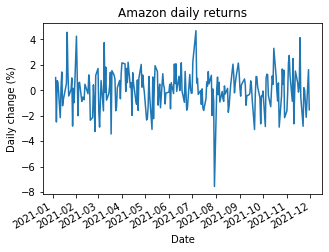

In [37]:
amzn_returns_ax = train_returns.plot(figsize=(5,3.5))
amzn_returns_ax.set_ylabel('Daily change (%)')
amzn_returns_ax.set_title('Amazon daily returns')
amzn_returns_ax.figure.savefig('plots/amzn_returns.png')

This looks like white noise. There is a mean of 0 with seemingly random variations either side of the mean. Good. 

Next, we plot the correlogram for the squared residuals, since the squared residuals are equivalent to the variance in the residuals. 

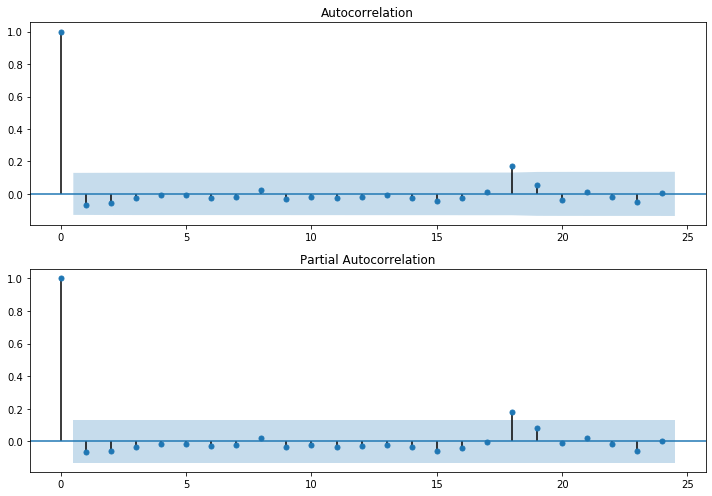

In [75]:
fig, (ax1, ax2) = plt.subplots(ncols=1,nrows=2, figsize=[10,7])
plot_acf(train_returns**2, ax=ax1)
plot_pacf(train_returns**2, ax=ax2)
fig.tight_layout()
# fig.savefig('plots/returns_acf_pacf.png')

From the ACF plot, we can see that there is some small correlation in variance at a lag of 2, and a significant correlation at a lag of 18. Therefore, 2 may be a reasonable choice for q (the number of lagged error terms) in the ARCH model.

From the PACF plot, we can see there is also a significant partial autocorrelation of variance at a lag of 18. 

So, let's fit a GARCH(18,18) model.

In [42]:
train_returns.tail()

Date
2021-11-23    0.209092
2021-11-24    0.010332
2021-11-26   -2.118468
2021-11-29    1.626738
2021-11-30   -1.530224
Name: Close, dtype: float64

In [62]:
def getForecast(p,q):
    model = arch_model(train_returns, mean='zero', p=p, q=q)
    model_fit = model.fit(disp='off')
    forecast = model_fit.forecast(horizon=30)
    return forecast.variance.values[-1,:]

In [66]:
getForecast(18,18)

array([3.30379276, 2.37724254, 1.60605449, 3.46541209, 2.77712776,
       1.44433522, 2.60835632, 1.58035152, 1.49737708, 2.2356294 ,
       6.05719692, 1.71679997, 3.70192551, 1.18979308, 1.77015713,
       3.0937829 , 3.21907796, 2.13416269, 3.23387392, 2.1520046 ,
       1.89422432, 2.92847612, 2.20446798, 1.80036431, 2.39737727,
       3.23205051, 1.8059831 , 3.50635603, 2.80129845, 2.07698667])

In [70]:
train_returns

Date
2021-01-05    1.000434
2021-01-06   -2.489665
2021-01-07    0.757717
2021-01-08    0.649557
2021-01-11   -2.151946
                ...   
2021-11-23    0.209092
2021-11-24    0.010332
2021-11-26   -2.118468
2021-11-29    1.626738
2021-11-30   -1.530224
Name: Close, Length: 229, dtype: float64

In [82]:
from arch.__future__ import reindexing
future_dates = [train_returns.index[-1] + timedelta(days=i) for i in range(1,31)]

volatility = pd.DataFrame(test_returns**2)
volatility['GARCH(2,2)'] = pd.Series(np.sqrt(getForecast(2,2)), index=future_dates)
volatility['GARCH(9,9)'] = pd.Series(np.sqrt(getForecast(9,9)), index=future_dates)
volatility['GARCH(18,18)'] = pd.Series(np.sqrt(getForecast(18,18)), index=future_dates)
volatility = volatility.rename(columns={"Close":"Actual Volatility"})

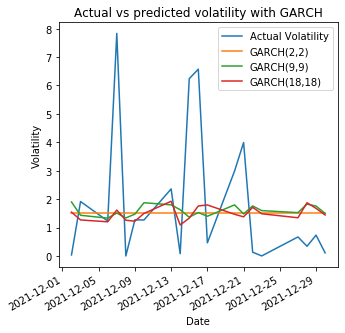

In [85]:
ax = volatility.plot(figsize=[5,5])
ax.set_title('Actual vs predicted volatility with GARCH')
ax.set_ylabel('Volatility')
ax.figure.savefig('plots/GARCH_volatility.png')

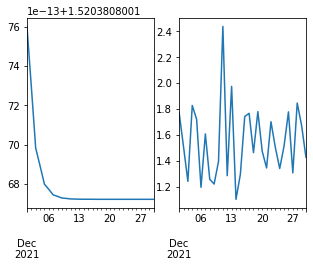

In [48]:
# pred_plot = amazon_data.plot(figsize=(10,4))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[5,3.5])
pred_1.plot(ax=ax1)
pred_2.plot(ax=ax2)

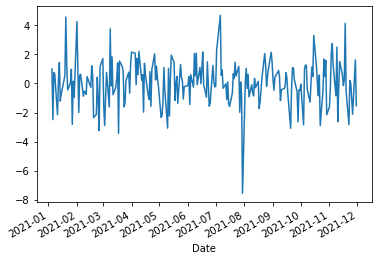

In [53]:
train_returns.plot()

In [49]:
plot_preds = pd.DataFrame(test_returns)
plot_preds['pred_returns'] = pred_2
plot_preds.head()

,Close,pred_returns
Date,,
2021-12-02,-0.184680,1.509328
2021-12-03,-1.383913,1.240973
2021-12-06,1.108626,1.195098
2021-12-07,2.798645,1.607214
2021-12-08,-0.003693,1.257254
